In [ ]:
!pip install pyro-ppl
!wget https://musicology.epfl.ch/data/dcml.tsv
!wget https://musicology.epfl.ch/data/profiles.tsv

     |████████████████████████████████| 678 kB 23.2 MB/s 
--2021-11-24 11:08:29--  https://musicology.epfl.ch/data/dcml.tsv
Resolving musicology.epfl.ch (musicology.epfl.ch)... 128.178.32.13, 2001:620:618:120:1:80b2:200d:1
Connecting to musicology.epfl.ch (musicology.epfl.ch)|128.178.32.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21322659 (20M) [application/octet-stream]
Saving to: ‘dcml.tsv’

dcml.tsv            100%[===================>]  20.33M  1.35MB/s    in 14s     

2021-11-24 11:08:44 (1.42 MB/s) - ‘dcml.tsv’ saved [21322659/21322659]

--2021-11-24 11:08:44--  https://musicology.epfl.ch/data/profiles.tsv
Resolving musicology.epfl.ch (musicology.epfl.ch)... 128.178.32.13, 2001:620:618:120:1:80b2:200d:1
Connecting to musicology.epfl.ch (musicology.epfl.ch)|128.178.32.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587676 (574K) [application/octet-stream]
Saving to: ‘profiles.tsv’

profiles.tsv        100%[=============

In [ ]:
import pyro
pyro.enable_validation()
import pyro.poutine as poutine
from pyro.distributions import *

import torch
from torch import nn

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [ ]:
device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 0. Basics of probability theory (skip if boring)


## Joint Distributions

Roughly speaking, a **joint probability distribution** $p(a,b,c)$ over a set of random variables (here $a$, $b$, and $c$) assings a probability between 0 and 1 to every assignment of the variables. For discrete variables, $p$ is given as a *probability mass function* (PMF), where each variable assignment has a ceratain probability:
$$p(a=\text{'A'}, b=1, c=\text{True}) = pmf_p(\text{'A'}, 1, \text{True}) = 0.34$$
 For continuous variables, $p$ is given as a *probability density function* (PDF), that gives the probability of a variable being within a certain range if integrated over that range:
$$p(a \in [1,2], b \in [-0.5,0.5], c>0.9) = \int_1^2 \int_{-0.5}^{0.5} \int_{0.9}^\infty pdf_p(a,b,c)\ dc\ db\ da$$
Discrete and continuous variables may be mixed too. For simplicity, we use sums in the examples below (as you would for discrete variables), but these translate to integrals for continuous variables.

## Views on the Joint Distributions

There are two fundamental operations on distributions that are of interest here. **Marginalization** "zooms" in on a subset of the random variables by summing/integrating out the others. The idea is to ask: "What is the distribution of these random variables regardles of the other variables?"
$$ p(a, b) = \sum_c p(a, b, c)\\
   p(a) = \sum_b p(a, b) = \sum_b \sum_c p(a, b, c)
$$

**Conditioning** also zooms in on a subset of the variables, but in contrast to marginalization, it assumes the values of the other variables to be known and asks: "What is the distribution over these variables if the other variables take some specific value?"

$$ p(a, b \mid c=3) = \dfrac{p(a, b, c=3)}{p(c=3)} = \dfrac{p(a, b, c=3)}{\sum_{a',b'} p(a=a', b=b', c=3)} $$

Both operations may be combined:

$$ p(a \mid c) = \sum_b p(a, b \mid c) = \sum_b \dfrac{p(a, b, c)}{\sum_{a',b'} p(a',b',c)} $$

As you can see, every "view" on a distribution can be expressed in terms of the joint distribution.

## Factorization

Using the definitions above, every distribution can be trivially decomposed into a number of conditional and marginal factors, e.g.
$$ p(a,b,c) = p(a)\ p(b \mid a)\ p(c \mid a, b) $$
or
$$ p(a,b,c) = p(c)\ p(b \mid c)\ p(a \mid c, b)$$

Even though all of these factorizations exist, it might not be possible to compute them efficiently.
However, sometimes it is reasonable to *define* a joint distribution through such a factorization, e.g. because there is a *process* that generates the value of each variable based on the values of other variables.

## Inference and Bayes' Rule

In probabilistic terms, **inference** is computing a conditional distribution. After observing some varibles ($x$), we would like to know what we have learned from this observation about the unobserved variables ($z$).
$$ p(z \mid x) = \dfrac{p(x,z)}{p(x)} = \dfrac{p(x,z)}{\sum_{z'} p(x, z')} $$

Since we have to sum/integrate over all unobserved variables (see above), exact inference is often not tractable.
In some cases we are lucky and the joint distribution is already factorized into $p(x) p(z \mid x)$.
However, it is more common that $z$ is some unknown property that *generates* $x$, so the join factorizes into a **prior** $p(z)$ and a **likelihood** $p(x \mid z)$.
This setup results in the equation known as [Bayes' Rule](https://en.wikipedia.org/wiki/Bayes%27_theorem):
$$ p(z \mid x) = \dfrac{p(x,z)}{p(x)} = \dfrac{p(x \mid z) p(z)}{p(x)} $$

The big question of this tutorial is how to compute $p(z \mid x)$.

# 1. Getting Started with Probabilistic Programming

Probabilistic programming is a convenient and very expressive way of writing probabilistic models and performing inference. In principle, every joint probability distribution can be factorized into a product of conditionals:

$$
  p(a,b,c) = p(a, b \mid c)\ p(c) = p(a \mid b, c)\ p(b \mid c)\ p(c)
$$

Such a factorization corresponds to a process that samples the random variables in a certain order:
1. Sample $c$ from $p(c)$
2. Sample $b$ from $p(b \mid c)$
3. Sample $a$ from $p(a \mid b, c)$

In this process, each variable knows the sampled value of all previous variables, so the local distribution can depend on these previous values (but it doesn't have to). This is exactly what happens in a probabilistic program: each variable is sampled from a local distribution that may depend on all previously sampled variables, as well as deterministic computations in between.

## A simple probabilistic program

In this tutorial, we use [pyro](https://http://pyro.ai), a probabilistic programming framework for Python.
A model in pyro is simply a normal (ideally pure) function that performs some computation.
Random variables are sampled using the function [`pyro.sample(name, dist)`](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.sample),
which takes a unique name that identifies the variable and a [distribution](https://docs.pyro.ai/en/stable/distributions.html) to sample from, e.g. a Bernoulli distribution for binary variables:

In [ ]:
pyro.sample("coin", pyro.distributions.Bernoulli(0.5))

tensor(1.)

If you run this cell several times, you will get different results.

### Exercise 1.1

In order to do anything useful with a probabilistic program, we usually encapsulate it in a function.

Let's implement the following random process:

1. Flip a fair coin.
2. If the coin is heads, return 'True', otherwise return 'False'.

We can use a Bernoulli distribution with probability 0.5 to model the coin flip.

In [ ]:
def coin1_model():
  coin = pyro.sample("coin", pyro.distributions.Bernoulli(0.5))
  print("coin:", coin)
  if coin.item() == 1.: # .item() retrives the value from a scalar torch tensor
    print("coin is heads")
    return True
  else:
    print("coin is tails")
    return False

In [ ]:
coin1_model()

coin: tensor(0.)
coin is tails


False

## A probabilistic program with several random variables

### Exercise 1.2

Implement the following process:

1. Flip a coin.
2. If the coin is heads, sample from a categorical distribution with probabilities '[0.5, 0.3, 0.2]'
   If the coin is tails, sample with probabilities '[0.1, 0.1, 0.8]'.
3. Return the sampled category.

In [ ]:
def coin2_model():
  coin = pyro.sample("coin", Bernoulli(0.5))
  if coin.item() == 1:
    cat = pyro.sample("cat", Categorical(torch.tensor([0.5, 0.3, 0.2])))
  else:
    cat = pyro.sample("cat", Categorical(torch.tensor([0.1, 0.1, 0.8])))
  return cat.item()

In [ ]:
coin2_model()

0

### Running the model to generate data

We can look at the full trace of the program by running it in a special context. Different execution contexts are used for different purposes such as tracing, inference, and prediction.

In [ ]:
# run in a tracing context:
with pyro.poutine.trace_messenger.TraceMessenger() as tracer:
  coin2_model()

# examine the trace:
for name, node in tracer.trace.nodes.items():
  print(f"{name} = {(node['value'])}")

coin = 0.0
cat = 2


### Simple Inference with Rejection Sampling

If some variables are observed, how does the distribution of the unobserved variables change? If the observed variables are at the top of the program, this is easy: we fix them and let the program run on, collecting samples of the remaining variables.

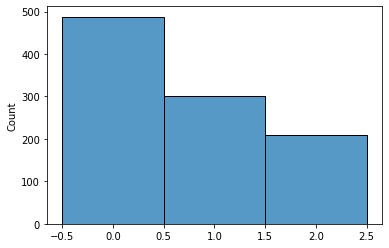

In [ ]:
coin_known_model = pyro.condition(coin2_model, data={"coin": torch.tensor(1.)})
cats = []
for i in range(1000):
  cat = coin_known_model()
  cats.append(cat)
sns.histplot(cats, discrete=True)

### Exercise 1.2: Rejection Sampling

However, we can't easily do this in the other direction.
If we just set the value of 'cat', then 'coin' will still be sampled from independently (i.e. from a fair coin), without looking at the value of cat (this is called "intervention"). Instead, we would like to know, how the probability of 'coin' *changes* if we observe 'cat'.

A simple way of doing this is using rejection sampling:
1. Run the model
2. If the model generated the expected value for 'cat', record the value of 'coin'.
3. Look at the distribution of 'coin' in only the runs where 'cat' had the correct value.

In [ ]:
def sample_coins_conditioned(cat_val):
  coins = []
  for i in range(1000):
    # trace the model, so we can inspect the intermediate variables
    with pyro.poutine.trace_messenger.TraceMessenger() as tracer:
      cat = coin2_model()
    if cat == cat_val:
      coins.append(tracer.trace.nodes['coin']['value'].item())
  return coins

# for testing:
sample_coins_conditioned(0)[0:10]

[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]

Text(0.5, 1.0, 'p(coin | cat = 2)')

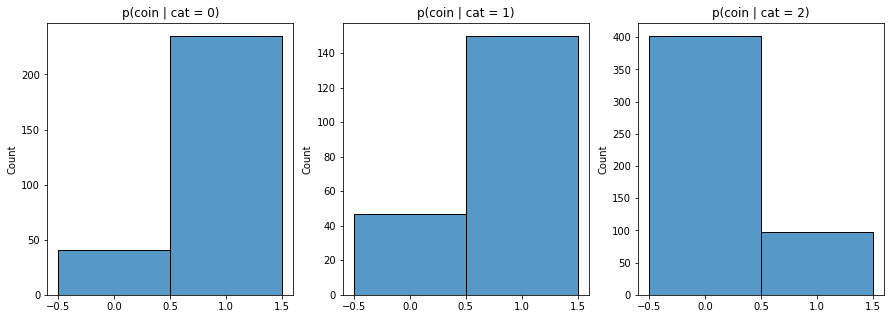

In [ ]:
# plot the sampled coins for every category
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(sample_coins_conditioned(0), discrete=True, ax=ax[0]).set_title("p(coin | cat = 0)")
sns.histplot(sample_coins_conditioned(1), discrete=True, ax=ax[1]).set_title("p(coin | cat = 1)")
sns.histplot(sample_coins_conditioned(2), discrete=True, ax=ax[2]).set_title("p(coin | cat = 2)")


# 2. Variational Inference

## Theory



Variational inference tries to approximate the true posterior $p(z \mid x)$ with a simpler **variational distribution** $q_\phi(z)$.
The variational distribution is a member of a family of distributions with some parameters ($\phi$), so the objective is to find good parameters so that $q_\phi(z)$ gets as close to $p(z \mid x)$ as possible.

One way to obtain good parameters is to minimize the KL-divergence between $q_\phi(z)$ and $p(z \mid x)$.
\begin{align}
D_{KL}(q_\phi(z) \parallel p(z \mid x))
 &= \sum_z q_\phi(z) \left[\log \dfrac{q_\phi(z)}{p(z \mid x)}\right] \\
 &= \sum_z q_\phi(z) \log q_\phi(z) - \sum_z q_\phi(z) \log p(x, z) + \log p(x)\\
ELBO &= \sum_z q_\phi(z) \log p(x, z) - \sum_z q_\phi(z) \log q_\phi(z)\\
     &= \log p(x) - D_{KL}(q_\phi(z) \parallel p(z \mid x))
\end{align}
Since $p(x)$ (the *evidence*) is a constant, we can ignore it for optimization purposes, so minimizing the KL-divergence is equivalent to maximizing the ELBO ([*evidence lower bound*](https://en.wikipedia.org/wiki/Evidence_lower_bound), note the change of sign).

Both terms in the ELBO take the form $\sum_z q_\phi(z) f(z)$ (i.e. $\mathbb{E}_{q_\phi}[f(z)]$), so they can be estimated by sampling $z$ from $q_\phi$ and applying these samples to $q_\phi$ and $p$. In a similar fashion, we can estimate the gradient of the ELBO wrt. $\phi$ by sampling from $q_\phi$. This gradient can be used to optimize $\phi$, which is exactly what *stochastic variational inference* (SVI) is doing. Pyro uses PyTorch to automatically derive this gradient (this is called automatic differentiation VI, ADVI).[link text](https://)

## Variational Inference in pyro

The variational family is described as a **guide** function.
The guide has the same signature as the model function, but it only samples the unobserved (latent) variables according to $q_\phi$.
A common strategy is to sample all latent variables independently from suitable distributions.
The parameters of these distributions (i.e. $\phi$) are registered using [`pyro.param(name, init_tensor)`](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.param) so that pyro knows what to optimize.
Every time the guide is called, pyro will
1. look up the current parameters from the parameter store,
2. run the guide to produce samples,
3. compute the gradient for each parameter, and
4. update each parameter using its gradient.

(On the first run, the `init_tensor` value will be used.)

Let's apply this strategy to infer the value of `coin` from an observation of `cat`.
Here, we only need to sample a single variable (`coin`), which can only take two values (0 or 1), so a Bernoulli distribution is appropriate.
However, the parameter of this distribution (i.e. the probability to get heads) needs to be registered, so pyro can optimize it to match the true posterior probability of the coin being heads.

In [ ]:
# for reference
def coin2_model():
  coin = pyro.sample("coin", Bernoulli(0.5))
  if coin.item() == 1:
    cat = pyro.sample("cat", Categorical(torch.tensor([0.5, 0.3, 0.2])))
  else:
    cat = pyro.sample("cat", Categorical(torch.tensor([0.1, 0.1, 0.8])))
  return cat.item()

def coin2_guide():
  # register the parameter to optimize:
  p_coin = pyro.param("p_coin", torch.tensor(0.5))
  # sample the value of the coin based on our current belief
  pyro.sample("coin", Bernoulli(p_coin))

Now we use this guide together with the model to perform SVI. We do this using pyro's [`SVI`](https://docs.pyro.ai/en/stable/inference_algos.html) class with a [`Trace_ELBO`](https://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.trace_elbo.Trace_ELBO) loss, a direct implementation of the ELBO shown above.

In [ ]:
def infer_coin_SVI(observed_cat, n_steps=5000):
  # clear parameters
  pyro.clear_param_store()
  # set the values of the observed variables
  conditioned_model = pyro.condition(coin2_model, {'cat': torch.tensor(observed_cat)})
  # setup the inference object
  optimizer = pyro.optim.Adam({'lr': 0.001})
  svi = pyro.infer.SVI(conditioned_model, coin2_guide, optimizer, pyro.infer.Trace_ELBO())

  # record some info
  loss_hist = []
  p_hist = []

  # run the optimization loop
  for i in tqdm.tqdm(range(n_steps)): # tqdm = progress bar
    # perform the update step
    current_loss = svi.step() # here you can provide parameters to model and guide, if needed
    # record the current loss
    loss_hist.append(current_loss)
    # record the value of p_coin
    p_hist.append(pyro.param('p_coin').item())

  # plot the results
  fig, ax = plt.subplots(1, 2, figsize=(15,5))
  ax[0].plot(loss_hist)
  ax[0].set_title("loss")
  ax[1].plot(p_hist)
  ax[1].set_title(f"p(heads | cat={observed_cat})")
  fig.tight_layout()
  print("final estimate: p_coin =", p_hist[-1])

100%|██████████| 5000/5000 [00:09<00:00, 540.89it/s]


final estimate: p_coin = 0.8147284388542175


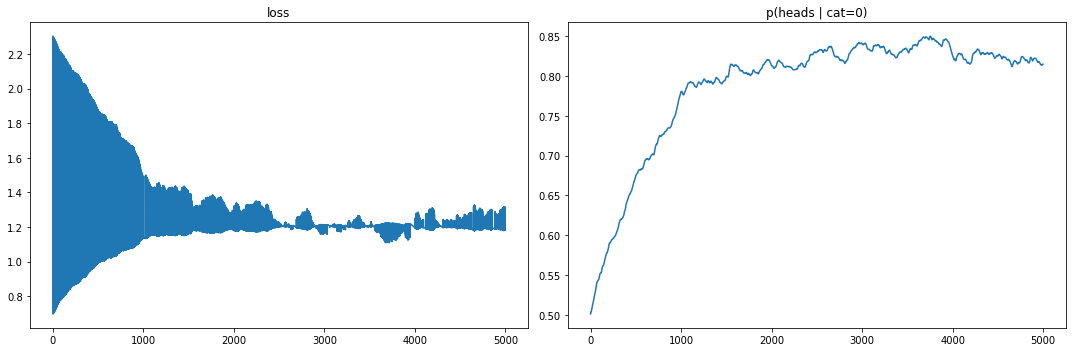

In [ ]:
infer_coin_SVI(0)

100%|██████████| 5000/5000 [00:08<00:00, 561.77it/s]


final estimate: p_coin = 0.7250193357467651


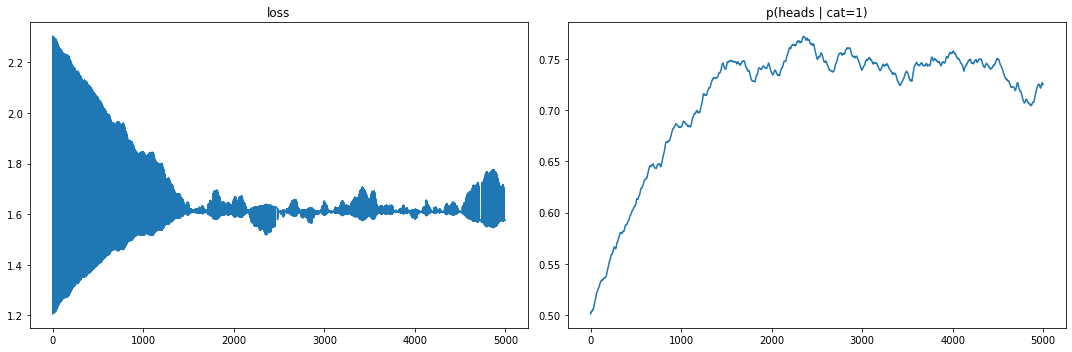

In [ ]:
infer_coin_SVI(1)

100%|██████████| 5000/5000 [00:09<00:00, 553.12it/s]


final estimate: p_coin = 0.20590168237686157


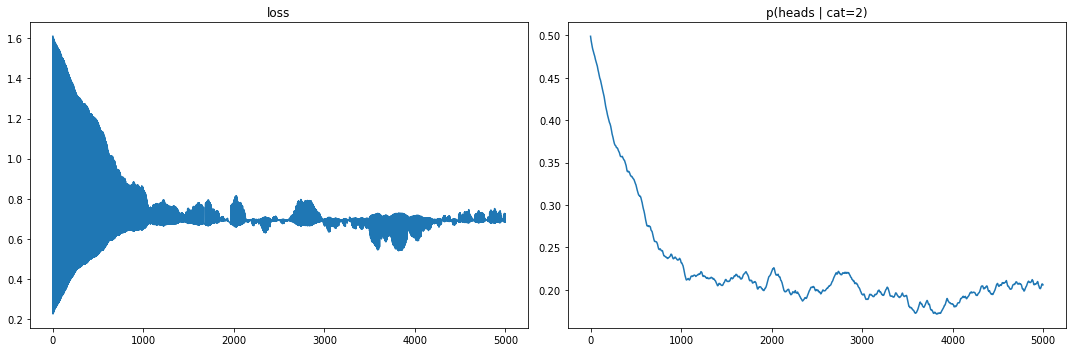

In [ ]:
infer_coin_SVI(2)

### Vectorization

In datasets, we usually deal with several samples drawn from the same distribution.
We can model this situation using `for` loops, but that's not very fast in Python, so we'll use vectorized representations instead (fortunately PyTorch works very similar to numpy).

Consider the case, where we have a coin with an unknown bias and we want to estimate the bias from a number of observations. The generative model looks like this:

1. Draw a random probability $\theta$ from a prior (e.g. Beta(1,1)).
2. For each coin flip $i$: sample the coin side $c_i \sim Bernoulli(\theta)$

A naive implementation could look like this:

In [ ]:
def coin3_naive_model(n_flips):
  theta = pyro.sample("theta", Beta(1, 1))
  print(f"theta = {theta}")
  coins = []
  for i in range(n_flips):
    coins.append(pyro.sample(f"coin_{i}", Bernoulli(theta)))
  return coins

coin3_naive_model(5)

theta = 0.8268820643424988


[tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.)]

Instead of considering each coin $c_i$ individually, we can treat $c$ as a vector of coins.
In pyro we can do that using a "plate", which indicates that the variables inside it are drawn independently from the same distribution ([i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)).
Within a [`pyro.plate(name, n)`](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.plate) context, all variables are automatically vectorized, so they gain another dimensions of size `n`:

In [ ]:
def coin3_vec_model(n_flips):
  theta = pyro.sample("theta", Beta(1, 1))
  print(f"theta = {theta}")
  with pyro.plate("coins", n_flips):
    coins = pyro.sample("coin", Bernoulli(theta))
  return coins

coin3_vec_model(5)

theta = 0.06266071647405624


tensor([0., 0., 0., 0., 0.])

Another advantage of plates is that they allow you to use minibatches.
Instead of sampling your complete dataset, you can tell them to use random subsamples of a certain size.
Subsampling is only done during inference, so if you just run your model, it will generate the whole dataset.

**Important**:
If you use subsampling, you can't use `pyro.condition()` to observe varibales.
Instead, you have to pass the observations to the model and manually observe the variables.
Use `with pyro.plate(...) as ind:` to obtain a vector of subsample indices `ind`, and then use `pyro.sample(name, dist, obs=data[ind])` to condition on a subsample of your data.
This is unfortuante because it prevents us from using the same model for inference and other tasks, but for now we have to live with that limitation.

In [ ]:
def coin3_subsample_model(n_flips, observed_coins):
  theta = pyro.sample("theta", Beta(1, 1))
  print(f"theta = {theta}")
  with pyro.plate("coins", n_flips, subsample_size=5) as ind:
    print(f"subsample = {ind}")
    coins = pyro.sample("coin", Bernoulli(theta), obs=observed_coins[ind])
  return coins

# this will return a subsample of the provided observations
coin3_subsample_model(10, torch.tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1]))

theta = 0.16627328097820282
subsample = tensor([6, 4, 5, 1, 8])


tensor([1, 0, 1, 0, 1])

## Example 1: Learning Chord Types

In this example we want to learn the properties of different chord types.
In our simple model, each chord type has a simple pitch profile that we represent as a probability vector $\theta_h$ over tonal pitch classes.
Every instance of a chord is a bag of pitches that is drawn from a multinomial distribution with $\theta_h$ as parameters.
Since the conjugate prior for a multinomial is a Dirichlet distribution, we use a Dirichlet prior for $\theta_h$.

The model now describes a generative process that "produces" the dataset.
For $N_h$ chord types and $N_c$ chords do:
1. For each chordtype $h \in 1 \ldots N_h$: sample $\theta_h \sim \text{Dirichlet}_{N_h}(1, \ldots)$
2. For each chord $i \in [1,N_c]$:
   1. sample $c_i \sim \text{Categorical}_{N_h}(1/N_h, \ldots)$
   2. sample $n_i \sim \text{Poisson}(1)$
   3. sample $\text{notes}_i \sim \text{Multinomial}(n_i + 1, \theta_{c_i})$

In the inference process, we then try to infer the posterior distribution of the chord-type profiles given the observed chords.

### Data and Plotting

In [ ]:
# n_pcs is the number of (relative) pitch classes we consider
fifths_range = 14
n_pcs = 1 + 2*fifths_range

def pc_to_index(fifth):
  """
  Return the array index of a relative pitch class given in fifths.
  """
  return (fifth+fifths_range) % n_pcs

# load data
dcml_df = pd.read_csv('dcml.tsv', sep='\t').drop(columns='type')[0:50000]
dcml_df = dcml_df[(dcml_df.fifth >= -fifths_range) & (dcml_df.fifth <= fifths_range)]

# fix the chord vocabulary
dcml_chord_types = ['M', 'Mm7', 'MM7', 'm', 'mm7', 'o', '%7', 'o7', '+']
dcml_df = dcml_df[dcml_df.label.map(lambda l: l in dcml_chord_types)]

sizes = dcml_df.groupby(['chordid', 'label']).size()
#type_counts = sizes.groupby('label').size().sort_values(ascending=False)
dcml_df['numlabel'] = dcml_df.label.map(dcml_chord_types.index)
dcml_n_types = len(dcml_chord_types)
dcml_n_chords = len(dcml_df.chordid.unique())
dcml_chord_notes = torch.zeros(dcml_n_chords, n_pcs)
dcml_chord_labels = torch.zeros(dcml_n_chords, dtype=int)
for i, ((_, label), grp) in enumerate(dcml_df.groupby(['chordid', 'numlabel'])):
  for note in grp.fifth:
    dcml_chord_notes[i, pc_to_index(note)] += 1
  dcml_chord_labels[i] = label

# important data
print("chord types:", dcml_chord_types)
print("notes (shape):", dcml_chord_notes.shape)
print("labels (shape):", dcml_chord_labels.shape)
print("dcml_n_chords =", dcml_n_chords)
print("dcml_n_types =", dcml_n_types)

# use this later on for conditioning
dcml_data = {'notes': dcml_chord_notes, 'c': dcml_chord_labels}
dcml_data

chord types: ['M', 'Mm7', 'MM7', 'm', 'mm7', 'o', '%7', 'o7', '+']
notes (shape): torch.Size([6541, 29])
labels (shape): torch.Size([6541])
dcml_n_chords = 6541
dcml_n_types = 9


{'c': tensor([3, 0, 3,  ..., 0, 0, 0]),
 'notes': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])}

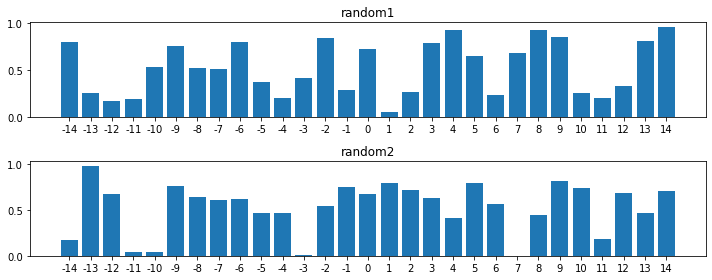

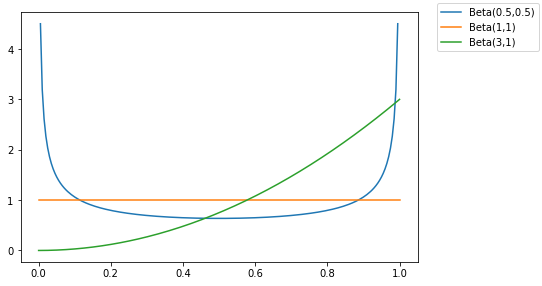

In [ ]:
# a helper for plotting chord types
def plot_chord_types(profiles, type_labels):
  n_types = profiles.shape[0]
  fig, ax = plt.subplots(n_types, 1, figsize=(10, 2*n_types))
  xlabels = np.arange(-fifths_range, fifths_range+1)
  x = np.arange(n_pcs)
  for i in range(n_types):
    ax[i].bar(x, profiles[i])
    ax[i].set_title(type_labels[i])
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(xlabels)
  fig.tight_layout()
  fig.show()

# a helper for plotting a set of beta distributions
def plot_betas(alphas, betas, labels):
  x = np.linspace(0, 1, 200)
  y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(alphas, betas)]).transpose()
  fig = plt.figure()
  plt.plot(x, y)
  fig.legend(labels, bbox_to_anchor=(1., 1), loc='upper left')
  fig.tight_layout()
  fig.show()

# example usage:
plot_chord_types(np.random.rand(2, n_pcs), ["random1", "random2"])
plot_betas([0.5, 1, 3], [0.5, 1, 1], ["Beta(0.5,0.5)", "Beta(1,1)", "Beta(3,1)"])

### Exercise 2.1

Let's start by defining the model the naive way, i.e. using for loops.

Remember that every random variable needs a unique name, so use the index variable of each loop together with the `f"name_{i}"` syntax to generate unique names in every iteration.

Have the model return the list of chord types and the list of generated chords as a tuple.

**Hints:**
- Use `.append()` to add an item to a list.
- Use `.int().item()` on the result of the Poisson sample ($n_i$) to make it compatible with [`Multinomial(total_count, probs)`](https://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.Multinomial).


In [ ]:
def simple_chord_model_naive(n_types, n_chords):
  types = []
  for h in range(n_types):
    type_h = pyro.sample(f"theta_{h}", Dirichlet(torch.ones(n_pcs)))
    types.append(type_h)
  chords = []
  for i in range(n_chords):
    c = pyro.sample(f"c_{i}", Categorical(torch.ones(n_types) / n_types)).item()
    n = pyro.sample(f"n_{i}", Poisson(1)).int().item()
    notes = pyro.sample(f"notes_{i}", Multinomial(n + 1, types[c]))
    chords.append({notes})
  return types, chords # not needed, only for inspection

In [ ]:
# run an example:
types, chords = simple_chord_model_naive(3, 5)

for i, prof in enumerate(types):
  print(f"profile {i}: {prof}")

for i, chord in enumerate(chords):
  print(f"chord {i}: {chord}")

profile 0: tensor([1.3863e-02, 4.6709e-02, 4.2898e-02, 2.2445e-05, 1.5496e-01, 3.0038e-02,
        4.2508e-02, 3.0574e-02, 1.5900e-02, 1.5713e-02, 5.5881e-02, 3.7498e-02,
        2.4438e-02, 1.1043e-02, 1.7454e-02, 8.6761e-02, 2.2486e-02, 1.6050e-02,
        6.0817e-02, 5.7992e-03, 2.5785e-02, 5.3488e-02, 5.4444e-03, 4.5438e-03,
        5.0402e-02, 6.5262e-02, 4.1816e-03, 1.2523e-02, 4.6951e-02])
profile 1: tensor([0.0949, 0.0143, 0.1124, 0.0125, 0.0848, 0.0014, 0.0063, 0.0067, 0.0168,
        0.0346, 0.0759, 0.0116, 0.0116, 0.0287, 0.0469, 0.0506, 0.0040, 0.0395,
        0.0116, 0.0765, 0.0163, 0.0105, 0.0117, 0.0693, 0.0029, 0.0147, 0.0179,
        0.1054, 0.0097])
profile 2: tensor([0.0264, 0.0033, 0.0325, 0.1121, 0.0538, 0.0176, 0.0524, 0.0989, 0.0318,
        0.0186, 0.0288, 0.0645, 0.0283, 0.0061, 0.0026, 0.0100, 0.0711, 0.0604,
        0.0314, 0.0045, 0.0544, 0.0234, 0.0040, 0.0070, 0.0085, 0.0051, 0.0175,
        0.0800, 0.0448])
chord 0: {tensor([0., 0., 0., 0., 1., 0., 0., 0.

### Exercise 2.2

Now let's try to rewrite this model using plates.
Here we need to apply a little hack:
Normally, pyro's distributions can take vectorized parameters, so that we can easily work with vectorized code.
However, the implementation for Multinomial is incomplete in that it doesn't accept a vector for total_count.
Fortunately, the total count is irrelevant if the variable (here: the chords) is observed, so instead of providing the true count here, we will just provide 1 and set the and the keyword `validate_args=False`.
Since we now don't have to worry about $n_c$ anymore, let's remove it from the model.

You can also introduce some subsampling here since you don't want to look at all chords in the dataset in every iteration (e.g. 500 chords per iteration, or fewer while you are testing).
Remember that using subsampling requires explitit observation of the data that's provided above.

In [ ]:
def simple_chord_model(n_types, n_chords, data):
  with pyro.plate("types", n_types):
    types = pyro.sample("theta", Dirichlet(torch.ones(n_pcs)))
  with pyro.plate("chords", n_chords, subsample_size=min(500, n_chords)) as sub:
    c = pyro.sample("c", Categorical(torch.ones(n_types) / n_types), obs=data['c'][sub])
    pyro.sample("notes", Multinomial(1, types[c], validate_args=False), obs=data['notes'][sub])

In [ ]:
simple_chord_model(dcml_n_types, 5, dcml_data)

### Exercise 2.3

Write a guide for the vectorized chord model.
Remember that you only need to sample the latent variables in the guide.
Also note that, while all chord types are sampled i.i.d. from the prior,
their posteriors will be different, so each type needs its own set of parameters. You still have to use sample the chord types inside the `"types"` plate, so the parameters need to be fully vectorized (i.e. a `n_types x n_pcs` matrix).
In addition, since the parameters of a Dirichlet distribution must be positive,
you can add the keyword `constraint=pyro.distributions.constraints.positive` to `pyro.params()`.

In [ ]:
def simple_chord_guide(n_types, n_chords, data):
  params_types = pyro.param("params_types", torch.ones(n_types, n_pcs), constraint=constraints.positive)
  with pyro.plate("types", n_types):
    pyro.sample("theta", Dirichlet(params_types))

In [ ]:
pyro.clear_param_store()
simple_chord_guide(dcml_n_types, 5, dcml_data)

### Exercise 2.4

Perform variational inference using the model and guide above.
Adapting the first SVI example to create some useful diagnostic graphs
(e.g. plot some of the parameters you optimize).

For conditioning, use the data as provided above.

**Hint:** The posterior parameters can become very large, so it takes a long time for them to converge.
You can use a large learning rate (e.g. 0.1) to speed up the optimization process for now.


In [ ]:
def infer_simple_chords_SVI(n_steps=15_000):
  # clear parameters
  pyro.clear_param_store()
  # setup the inference object
  #optimizer = pyro.optim.SGD({'nesterov':True, 'momentum':0.1, 'lr':0.001})
  optimizer = pyro.optim.Adam({'lr': 0.1})
  svi = pyro.infer.SVI(simple_chord_model, simple_chord_guide, optimizer, pyro.infer.Trace_ELBO())

  # record some info
  loss_hist = []
  root_hist = torch.zeros(n_steps, dcml_n_types)

  # run the optimization loop
  for i in tqdm.tqdm(range(n_steps)): # tqdm = progress bar
    # perform the update step
    current_loss = svi.step(dcml_n_types, dcml_n_chords, dcml_data)
    # record the current loss
    loss_hist.append(current_loss)
    # record the root probability of each chords
    root_hist[i, torch.arange(dcml_n_types)] = pyro.param('params_types')[:, pc_to_index(0)].detach()

  # plot the diagnostics
  fig, ax = plt.subplots(1, 2, figsize=(15,5))
  ax[0].plot(loss_hist)
  ax[0].set_title("loss")
  ax[1].plot(root_hist)
  ax[1].set_title("roots")
  fig.tight_layout()
  return pyro.param('params_types').detach().numpy()

100%|██████████| 15000/15000 [01:14<00:00, 202.04it/s]


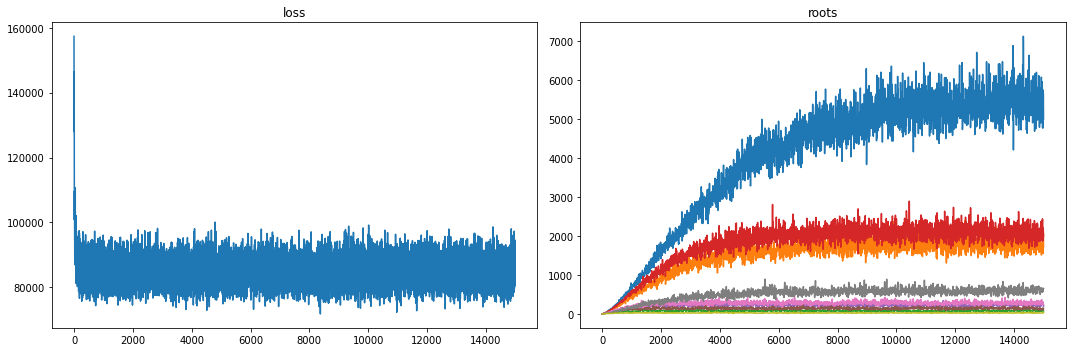

In [ ]:
inferred_types = infer_simple_chords_SVI()

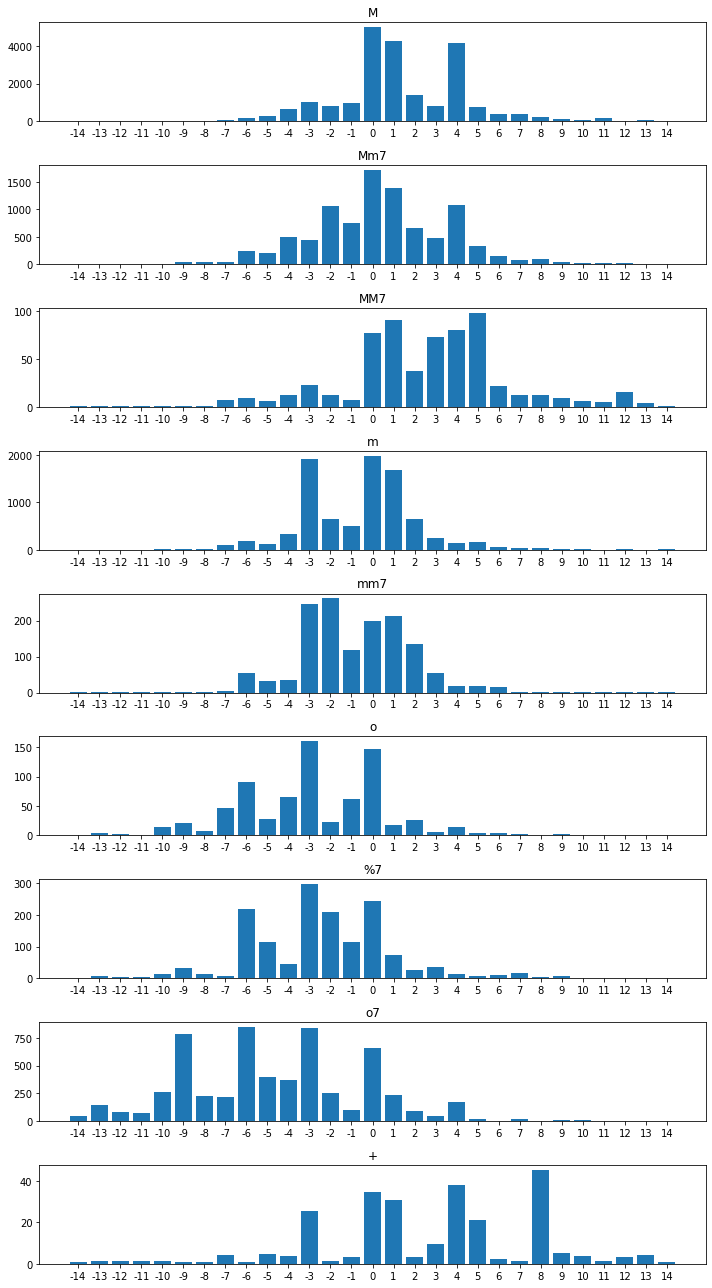

In [ ]:
plot_chord_types(inferred_types, dcml_chord_types)

## Example 2: A More Complex Chord Model

The previous model of chord types is not very interesting (and could be solved much faster analytically).
Let's now consider a more sophisticated model that cannot be (easily) solved analytically.
We now don't assume the different chord types to be independent anymore.
Instead, we derive them from triadic prototypes: major-like (M, MM7, Mm7), minor-like (m, mm7), diminished (o, %7, o7), and augmented (+).

In [ ]:
# chord types and prototypes
dcml_chord_prototypes = ['[M]', '[m]', '[o]', '[+]']
dcml_n_prototypes = len(dcml_chord_prototypes)
dcml_chord_grouping = {
    'M': '[M]',
    'MM7': '[M]',
    'Mm7': '[M]',
    'm': '[m]',
    'mm7': '[m]',
    'o': '[o]',
    '%7': '[o]',
    'o7': '[o]',
    '+': '[+]'
}

# mapping from numeric chord types to prototypes: 0=[M], 1=[m], 2=[o], 3=[+]
dcml_chord_prototype_mapping = torch.tensor([dcml_chord_prototypes.index(dcml_chord_grouping[ct])
                                             for ct in dcml_chord_types])
dcml_chord_prototype_mapping

tensor([0, 0, 0, 1, 1, 2, 2, 2, 3])

### Exercise 2.5 (Bonus)

With this mapping in place, define a model that has the following properties:
- Chord prototypes are independent templates
- Chord types are a linear combination (weighted average) of the prototype template and a type-specific template
- The weighting of prototype and type is unknown and type-specific but has a bias towards the prototype (to avoid putting everything into the specific templates).

Implement model, guide, and inference as above.

In [ ]:
def fancy_chord_model(n_prototypes, n_types, n_chords, mapping, data):
  # prototype profiles
  with pyro.plate("prototypes", n_prototypes):
    protos = pyro.sample("proto_theta", Dirichlet(torch.ones(n_pcs)))

  # type-specific profiles and weights
  with pyro.plate("types", n_types):
    types_specific = pyro.sample("type_theta", Dirichlet(torch.ones(n_pcs)))
    types_weight = pyro.sample("type_weights", Beta(3, 1)).reshape(n_types, 1)
    types = torch.multiply(protos[mapping], types_weight) + torch.multiply(types_specific, 1-types_weight)

  # chords
  with pyro.plate("chords", n_chords, subsample_size=min(500, n_chords)) as sub:
    c = pyro.sample("c", Categorical(torch.ones(n_types) / n_types), obs=data['c'][sub])
    pyro.sample("notes", Multinomial(1, types[c], validate_args=False), obs=data['notes'][sub])

  return protos, types, chords

# example run
protos, types, chords = fancy_chord_model(2, 4, 5, [0, 1, 0, 1], dcml_data)
print(protos)
print(types)
print(chords)

tensor([[0.0371, 0.0327, 0.0105, 0.0308, 0.0045, 0.0175, 0.0614, 0.0245, 0.0717,
         0.0086, 0.0050, 0.1225, 0.0038, 0.1231, 0.0182, 0.0141, 0.0239, 0.0184,
         0.0202, 0.0009, 0.1029, 0.0560, 0.0418, 0.0859, 0.0310, 0.0009, 0.0093,
         0.0107, 0.0120],
        [0.0422, 0.0066, 0.0334, 0.0164, 0.0734, 0.0233, 0.0859, 0.0524, 0.0302,
         0.0140, 0.1281, 0.0066, 0.0018, 0.1236, 0.0053, 0.0192, 0.0137, 0.0193,
         0.0022, 0.0320, 0.0457, 0.0670, 0.0041, 0.0697, 0.0049, 0.0370, 0.0199,
         0.0070, 0.0153]])
tensor([[0.0495, 0.0386, 0.0153, 0.0459, 0.0104, 0.0125, 0.0414, 0.0215, 0.0580,
         0.0345, 0.0122, 0.0838, 0.0059, 0.0898, 0.0151, 0.0442, 0.0162, 0.0172,
         0.0184, 0.0042, 0.0699, 0.0417, 0.0593, 0.0573, 0.0247, 0.0122, 0.0307,
         0.0543, 0.0153],
        [0.0338, 0.0373, 0.0454, 0.0215, 0.0450, 0.0277, 0.1036, 0.0298, 0.0176,
         0.0126, 0.0696, 0.0380, 0.0570, 0.0768, 0.0077, 0.0221, 0.0110, 0.0148,
         0.0228, 0.0314, 0.033

In [ ]:
def fancy_chord_guide(n_prototypes, n_types, n_chords, mapping, data):
  # prototypes
  params_protos = pyro.param("params_protos", torch.ones(n_prototypes, n_pcs), constraint=constraints.positive)
  with pyro.plate("prototypes", n_prototypes):
    pyro.sample("proto_theta", Dirichlet(params_protos))

  # types
  params_types = pyro.param("params_types", torch.ones(n_types, n_pcs), constraint=constraints.positive)
  params_weights_alpha = pyro.param("params_weights_alpha", 3 * torch.ones(n_types), constraint=constraints.positive)
  params_weights_beta = pyro.param("params_weights_beta", torch.ones(n_types), constraint=constraints.positive)
  with pyro.plate("types", n_types):
    pyro.sample("type_theta", Dirichlet(params_types))
    pyro.sample("type_weights", Beta(params_weights_alpha, params_weights_beta))

# just to see that the guide runs through
pyro.clear_param_store()
fancy_chord_guide(2, 4, 5, [0, 1, 0, 1], None)

In [ ]:
def infer_fancy_chords_SVI(n_steps=10_000):
  # clear parameters
  pyro.clear_param_store()
  # setup the inference object
  #optimizer = pyro.optim.SGD({'nesterov':True, 'momentum':0.1, 'lr':0.001})
  optimizer = pyro.optim.Adam({'lr': 0.1})
  svi = pyro.infer.SVI(fancy_chord_model, fancy_chord_guide, optimizer, pyro.infer.Trace_ELBO())

  # record some info
  loss_hist = []
  root_hist = torch.zeros(n_steps, dcml_n_types)

  # run the optimization loop
  for i in tqdm.tqdm(range(n_steps)): # tqdm = progress bar
    # perform the update step
    current_loss = svi.step(dcml_n_prototypes, dcml_n_types, dcml_n_chords, dcml_chord_prototype_mapping, dcml_data)
    # record the current loss
    loss_hist.append(current_loss)
    # record the root probability of each chords
    root_hist[i, torch.arange(dcml_n_types)] = pyro.param('params_types')[:, pc_to_index(0)].detach()

  # plot the diagnostics
  fig, ax = plt.subplots(1, 2, figsize=(15,5))
  ax[0].plot(loss_hist)
  ax[0].set_title("loss")
  ax[1].plot(root_hist)
  ax[1].set_title("roots")
  fig.tight_layout()

  # return the results
  prototypes = pyro.param('params_protos').detach().numpy()
  types_specific = pyro.param('params_types').detach().numpy()
  weight_alphas = pyro.param('params_weights_alpha').detach().numpy()
  weight_betas = pyro.param('params_weights_beta').detach().numpy()
  return prototypes, types_specific, weight_alphas, weight_betas

100%|██████████| 10000/10000 [01:32<00:00, 108.67it/s]


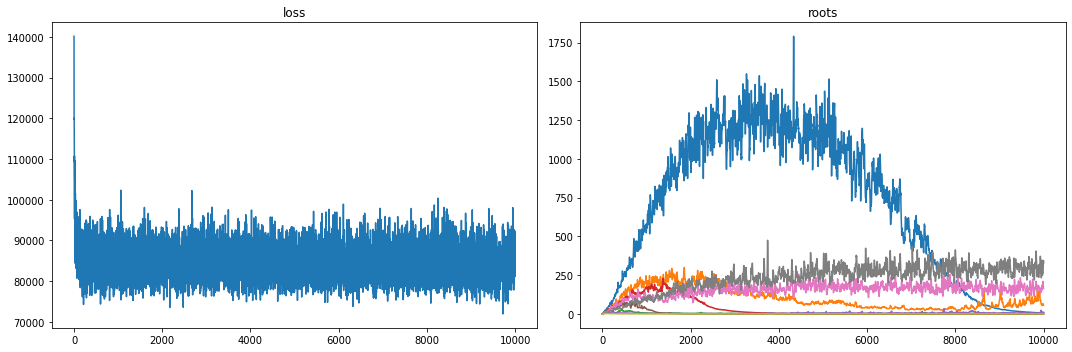

In [ ]:
fancy_results = infer_fancy_chords_SVI()

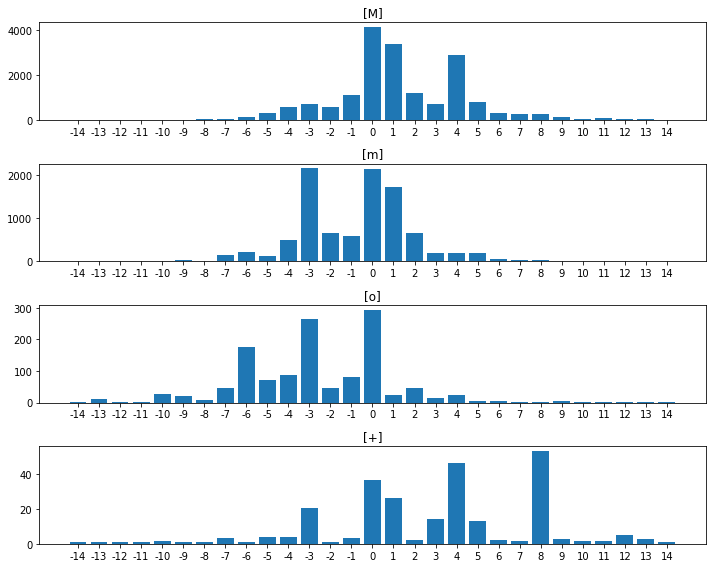

In [ ]:
plot_chord_types(fancy_results[0], dcml_chord_prototypes)

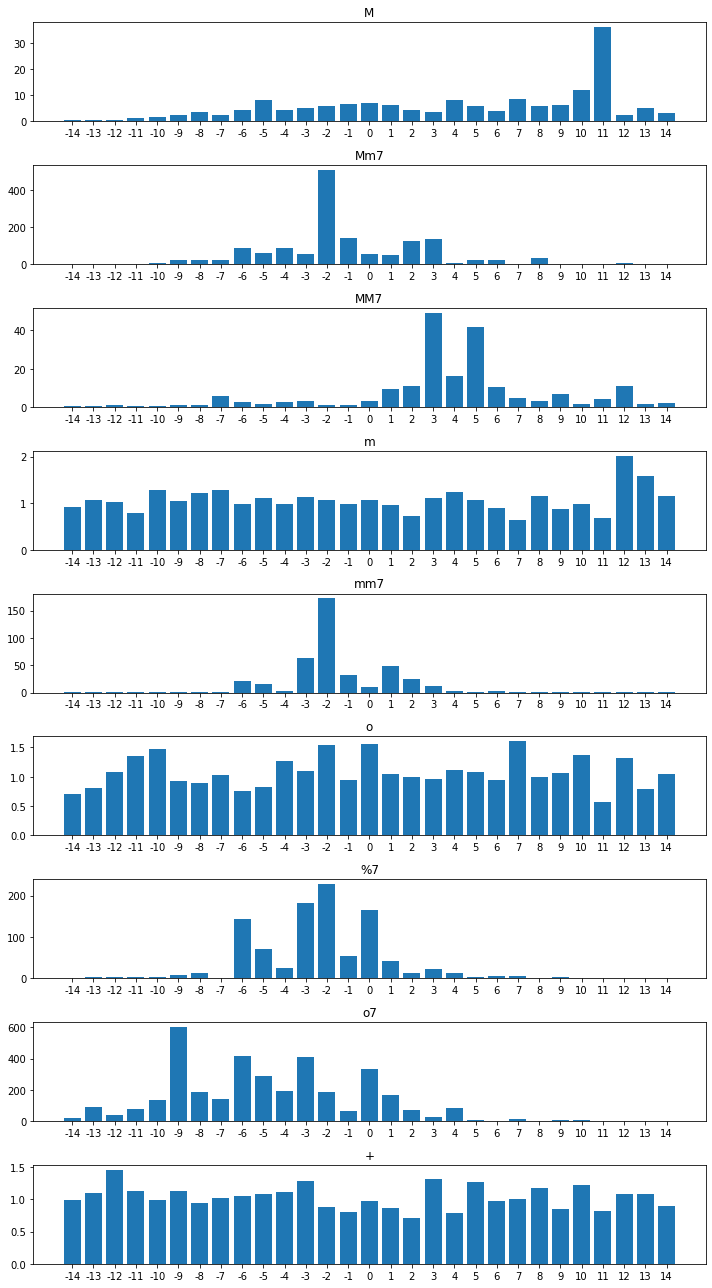

In [ ]:
plot_chord_types(fancy_results[1], dcml_chord_types)

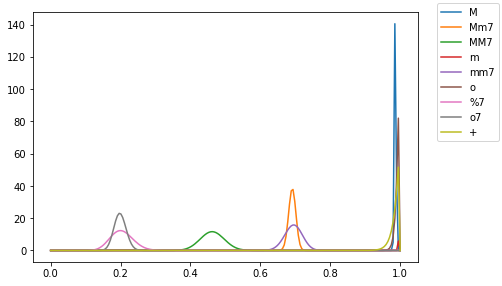

In [ ]:
plot_betas(fancy_results[2], fancy_results[3], dcml_chord_types)

# 3. MCMC

- theoretical idea
- one algorithm (e.g. MH, Gibbs, etc.)
- practice in pyro
- musical examples
  - unsupervised modes

# 4. Amortized Inference and Neural Networks

## Amortized Inference

When doing variational inference with *local* latent variables, your variational family (guide) needs to keep track of a separate set of parameters for each datapoint.
For example, with a model like this
$$ p(\vec{x}, \vec{z}, g) = p(g) \prod_i p(z_i \mid g) p(x_i \mid z_i, g), $$
the guide might look like this
$$ q_\phi(\vec{z}, g) = q_{\phi_g}(g) \prod_i q_{\phi_{zi}}(z_i), $$
so $\phi_{zi}$ is a set of parameters for each datapoint.

Instead of infering the parameters for each $z_i$ individually, we could try to learn a function $f_{\phi_f}$ that takes an $x_i$ and returns the (approximately) correct parameters $\phi_{zi}$ that correspond to $x_i$:
$$ q_\phi (\vec{z}, g) = q_{\phi_g} \prod_i q_{f_{\phi_f}(x_i)}(z_i) $$

Note that $f$ only has a single set of parameters ($\phi_f$) that are shared across all datapoints.
If $f$ is differentiable with respect to $\phi_f$, we can backpropagate every gradient on $\phi_{zi}$ through $f(x_i)$.
Since pyro is already build on PyTorch to perform automatic differentiation / backpropagation, we can use all of PyTorch's machinery (e.g. its neural networks modules) to build these trainable functions.

## Example: Unsupervised Chord Types

Let's change our chord type model from above a bit:
Instead of observing the labels of each chord,
we only observe the notes and try to infer both useful chord types and labels for the actual chords.
We could use the sampling approach used above,
but this time we combine variational inference with ammortization.
In the guide, we learn both chord types and a function that infers the chord type of a given set of notes.

### Data

### Exercise 4.1

Adapt the guide of the old model to only observe the notes of each chord, not the label.

In [ ]:
def amortized_chord_model(n_types, n_chords, chords):
  # sample types
  with pyro.plate("types", n_types):
    types = pyro.sample("theta", Dirichlet(torch.ones(n_pcs, device=device)))
  # sample chords
  with pyro.plate("chords", n_chords) as sub:
    # sample type according to type prevalence
    c = pyro.sample("c", Categorical(torch.ones(n_types, device=device) / n_types))
    # sample notes according to type
    pyro.sample("notes", Multinomial(1, types[c], validate_args=False), obs=chords[sub])

In [ ]:
amortized_chord_model(3, 5, dcml_data['notes'])

### Exercise 4.2

In PyTorch, neural networks are typically encapsulated in a class, which allows for simple tracking of parameters.
We will keep both the guide and the network itself in this class to make it easier to handle the internal state of the model.


Implement a guide that uses a simple neural network to sample the chord labels (`c`).
Don't forget to use subsampling in the "chords" plate (same as in the model).

In [ ]:
def normalize_notes(notes):
  scale = 1/torch.max(notes, dim=1).values
  return torch.mul(notes, scale.reshape(len(scale), 1))

class AmortizedChordGuide(nn.Module):
  # initialize the internal NN
  def __init__(self, n_types):
    super().__init__()
    hidden = 32
    # this is our "learnable function"
    self.f = nn.Sequential(
        nn.Linear(n_pcs, hidden),
        nn.SELU(),
        nn.Dropout(0.2),
        nn.Linear(hidden, n_types),
        nn.Softmax(dim=1) # outputs a normalized vector (= "probabilities")
    )

  def predict_label(self, notes):
    return self.f(normalize_notes(notes))

  # Same as above, but we also sample the label of each chord.
  # The probabilities for c_i are given by f(notes_i).
  # Remember to use the subsampling index when applying f to notes.
  def guide(self, n_types, n_chords, chords):
    # register the module in the pyro param store
    pyro.module("chord_predictor", self)

    # sample chord types
    params_types = pyro.param("params_types",\
                              #10 * (torch.rand(n_types, n_pcs, device=device)>0.5)\
                              #+ torch.ones(n_types, n_pcs, device=device),\
                              torch.ones(n_types, n_pcs, device=device),
                              constraint=constraints.positive)
    with pyro.plate("types", n_types):
      types = pyro.sample("theta", Dirichlet(params_types))

    # sample chord labels
    with pyro.plate("chords", n_chords, subsample_size=min(500, n_chords)) as sub:
      params_c = self.predict_label(chords[sub])
      labels = pyro.sample("c", Categorical(params_c))

    return types, labels, params_types

In [ ]:
test_guide_module = AmortizedChordGuide(3).to(device)
print(test_guide_module.predict_label(dcml_data['notes']))

pyro.clear_param_store()
test_types, test_labels,params_types = test_guide_module.guide(3, 5, dcml_data['notes'])
print(test_types)
print(test_labels)
print(params_types)

tensor([[0.2815, 0.3639, 0.3546],
        [0.2905, 0.3435, 0.3660],
        [0.3267, 0.3096, 0.3637],
        ...,
        [0.3001, 0.3380, 0.3619],
        [0.3290, 0.3417, 0.3294],
        [0.2517, 0.4007, 0.3476]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0201, 0.0035, 0.0139, 0.0304, 0.0069, 0.0226, 0.0568, 0.0806, 0.0457,
         0.0042, 0.0009, 0.0526, 0.0310, 0.0113, 0.0579, 0.0020, 0.0115, 0.0940,
         0.0182, 0.0736, 0.0017, 0.1064, 0.0062, 0.1007, 0.0013, 0.0124, 0.0905,
         0.0400, 0.0030],
        [0.0219, 0.0383, 0.0109, 0.0242, 0.1196, 0.0158, 0.0019, 0.0344, 0.0209,
         0.0723, 0.0006, 0.0195, 0.0440, 0.0447, 0.0378, 0.0349, 0.0200, 0.1117,
         0.0028, 0.0882, 0.0016, 0.0197, 0.0018, 0.0590, 0.0044, 0.0733, 0.0197,
         0.0408, 0.0153],
        [0.1397, 0.0437, 0.0323, 0.0104, 0.0052, 0.0781, 0.0008, 0.0161, 0.0102,
         0.0195, 0.0916, 0.0343, 0.0082, 0.0432, 0.0062, 0.0949, 0.0418, 0.0063,
         0.0984, 0.0908, 0.0049, 0.0238, 0.0422, 0.001

### Exercise 4.3

Adapt the inference code from above to perform VI using our ammortized guide:
Create an instance of `AmmortizedChordGuide` and provide `.guide` to `SVI`.

**Hint:** Cluster inference is very fragile, so choose a sufficiently small learning rate (e.g. 0.005).
Otherwise it can happen that the model assigns everything to a single cluster.

In [ ]:
def infer_amortized_chords_SVI(n_clusters, n_steps=5000):
  # clear parameters and setup guide module
  pyro.clear_param_store()
  guide_module = AmortizedChordGuide(n_clusters).to(device)
  # setup the inference object
  optimizer = pyro.optim.Adam({'lr': 0.005})
  svi = pyro.infer.SVI(amortized_chord_model, guide_module.guide, optimizer, pyro.infer.Trace_ELBO())

  # record some info
  loss_hist = []
  prev_hist = torch.zeros(n_steps, n_clusters, device=device)

  # run the optimization loop
  for i in tqdm.tqdm(range(n_steps)): # tqdm = progress bar
    # perform the update step
    current_loss = svi.step(n_clusters, dcml_n_chords, dcml_data['notes'])
    # record the current loss
    loss_hist.append(current_loss)
    # record the root probability of each chords
    prev_hist[i, torch.arange(n_clusters)] = pyro.param('params_types').detach()[:, pc_to_index(0)]

  # plot the diagnostics
  fig, ax = plt.subplots(1, 2, figsize=(15,5))
  ax[0].plot(loss_hist)
  ax[0].set_title("loss")
  ax[1].plot(prev_hist.cpu())
  ax[1].set_title("roots")
  fig.tight_layout()
  return pyro.param('params_types').detach().cpu().numpy(), guide_module

100%|██████████| 5000/5000 [00:42<00:00, 118.79it/s]


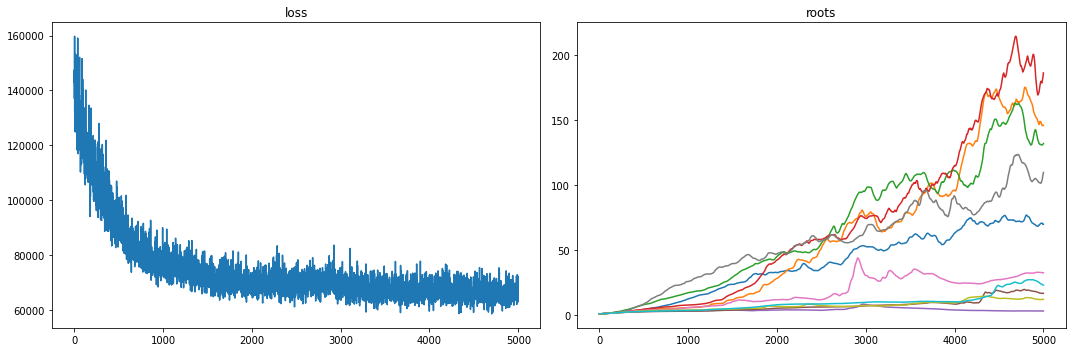

In [ ]:
inferred_clusters, chord_predictor = infer_amortized_chords_SVI(10, n_steps=5_000)

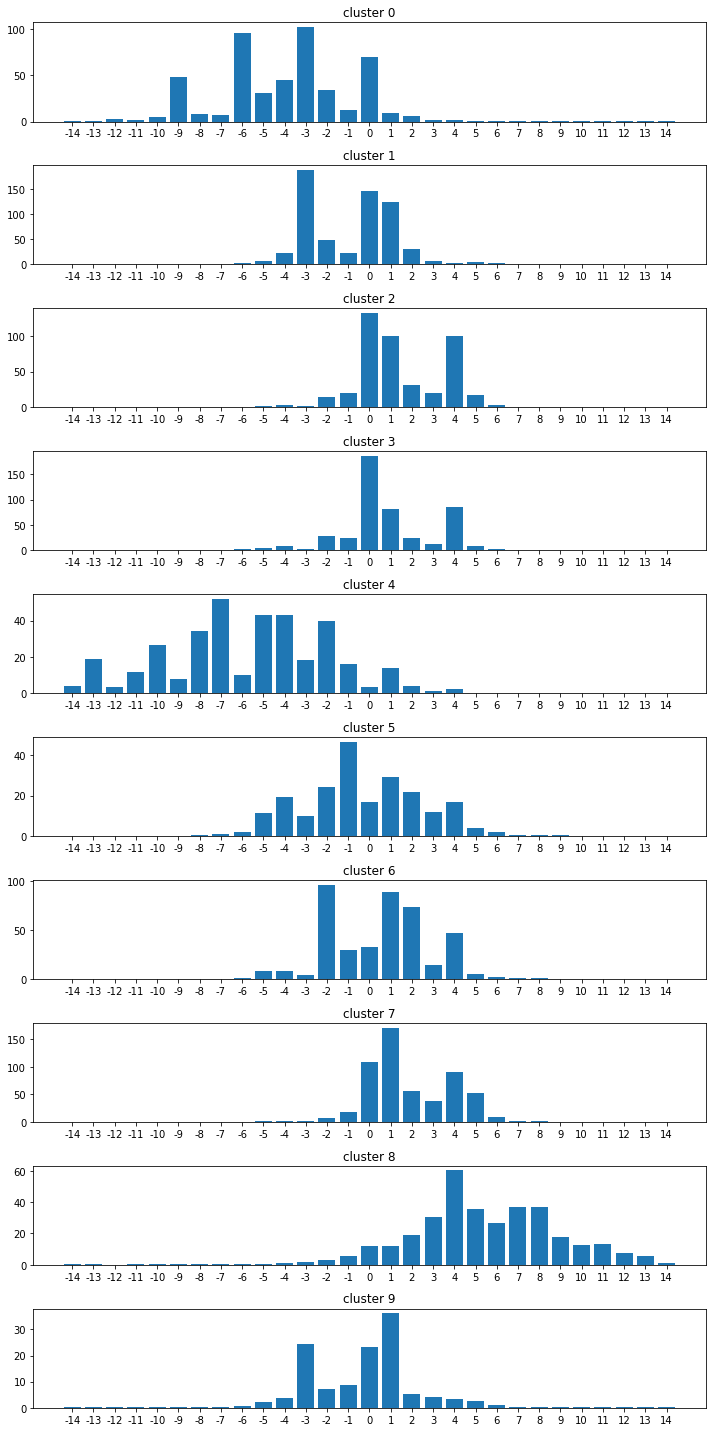

In [ ]:
plot_chord_types(inferred_clusters, [f"cluster {i}" for i in range(100)])

## Example: Clusters with priors

In the above example, we used uniform priors over the chord profiles.
This makes it difficult for the model to distinguish the clusters and assign too much probability mass on a single cluster.

Let's now use more theoretically informed priors that encode some hypotheses:
- chords can be related to diatonics, i.e. ranges of fifths around the root
- chords can be constructed symmetrically by stacking specific intervals

Adapt the above model to use priors encoding these hypotheses.
Infer the unsupervised posteriors as before and see, which clusters are actually used.
Note that because of the size of the data, you might have to provide relatively strong priors, otherwise the initial randomness of the type assignment can quickly overrule the prior.

Here are some useful priors to get you started:

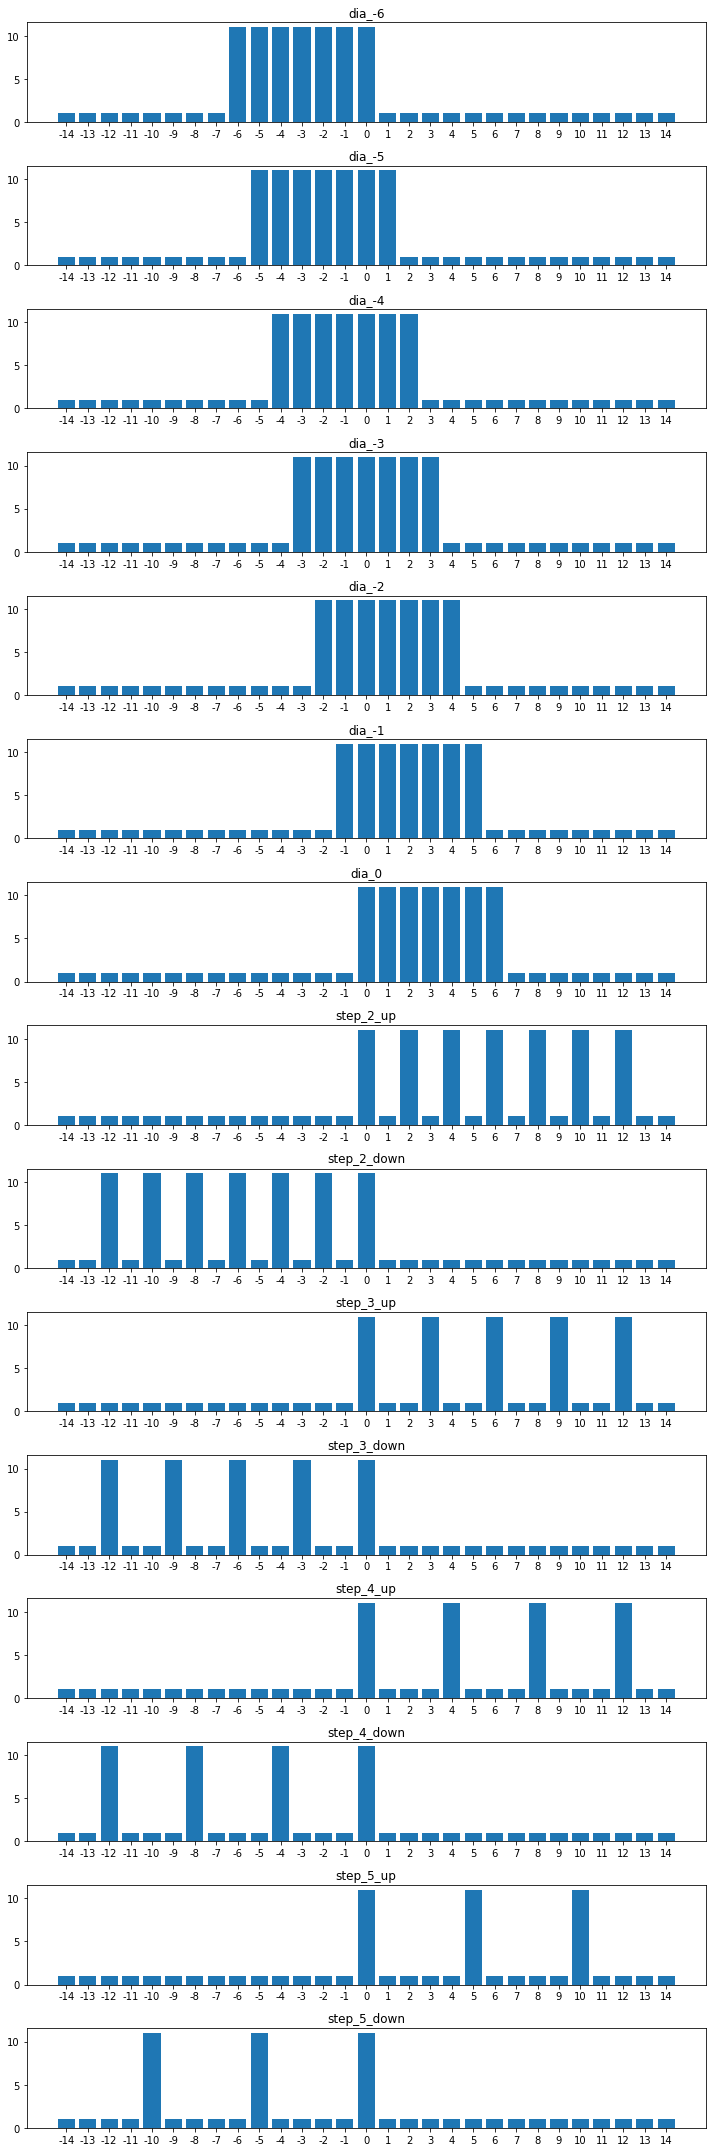

In [ ]:
# create informed cluster priors
cluster_priors_list = []
# diatonics
for i in range(7):
  dia = torch.zeros(n_pcs)
  dia[pc_to_index(i-6):pc_to_index(i+1)] = 1
  cluster_priors_list.append(dia)
# stacked intervals
for step in range(2, 6):
  pattern = torch.zeros(n_pcs)
  for j in range(0, fifths_range, step):
    pattern[pc_to_index(j)] = 1
  cluster_priors_list.append(pattern)
  cluster_priors_list.append(pattern.flip(0))

cluster_names = [f"dia_{i-6}" for i in range(7)] + [label for i in range(2,6) for label in [f"step_{i}_up", f"step_{i}_down"]]

cluster_priors = torch.stack(cluster_priors_list)
cluster_priors = 10 * cluster_priors + 1 # scale the prior (make sure to not have any zeros)
plot_chord_types(cluster_priors, cluster_names)

Now adapt the above model to use these priors.

**Hint:** Since the types are not sampled i.i.d. anymore, don't use a plate, but sample from the prior tensor instead.
You can do that using `pyro.sample("theta", Dirichlet(priors).to_event(1))`.
The `.to_event(1)` tells pyro that one dimension of `priors` is used for different variables (i.e. each chord type), while the remaining dimensions are the distribution parameters within each variable.



In [ ]:
def prior_cluster_model(n_chords, priors, chords):
  n_types = priors.shape[0]
  # sample types
  types = pyro.sample("theta", Dirichlet(priors).to_event(1))
  # sample chords
  with pyro.plate("chords", n_chords) as sub:
    # sample type according to type prevalence
    c = pyro.sample("c", Categorical(torch.ones(n_types) / n_types))
    # sample notes according to type
    pyro.sample("notes", Multinomial(1, types[c], validate_args=False), obs=chords[sub])

class PriorClusterGuide(nn.Module):
  def __init__(self, n_types):
    super().__init__()
    hidden = 32
    # this is our "learnable function"
    self.f = nn.Sequential(
        nn.Linear(n_pcs, hidden),
        nn.SELU(),
        nn.Dropout(0.2),
        nn.Linear(hidden, n_types),
        nn.Softmax(dim=1) # outputs a normalized vector (= "probabilities")
    )

  def predict_label(self, notes):
    return self.f(normalize_notes(notes))

  def guide(self, n_chords, priors, chords):
    # register the module in the pyro param store
    pyro.module("chord_predictor", self)

    # sample chord types
    n_types = priors.shape[0]
    params_types = pyro.param("params_types", priors.clone().detach(), constraint=constraints.positive)
    #params_types = pyro.param("params_types", torch.ones(n_types, n_pcs, device=device), constraint=constraints.positive)
    types = pyro.sample("theta", Dirichlet(params_types).to_event(1))

    # sample chord labels
    with pyro.plate("chords", n_chords, subsample_size=min(10_000, n_chords)) as sub:
      params_c = self.predict_label(chords[sub])
      labels = pyro.sample("c", Categorical(params_c))

    return types, labels, params_types

def infer_prior_clusters_SVI(priors, n_steps=5_000):
  n_clusters = priors.shape[0]
  # clear parameters and setup guide module
  pyro.clear_param_store()
  guide_module = PriorClusterGuide(n_clusters)
  # setup the inference object
  optimizer = pyro.optim.Adam({'lr': 0.005})
  svi = pyro.infer.SVI(prior_cluster_model, guide_module.guide, optimizer, pyro.infer.Trace_ELBO())

  # record some info
  loss_hist = []
  prev_hist = torch.zeros(n_steps, n_clusters)

  # run the optimization loop
  for i in tqdm.tqdm(range(n_steps)): # tqdm = progress bar
    # perform the update step
    current_loss = svi.step(dcml_n_chords, priors, dcml_data['notes'])
    # record the current loss
    loss_hist.append(current_loss)
    # record the root probability of each chords
    prev_hist[i, torch.arange(n_clusters)] = pyro.param('params_types').detach()[:, pc_to_index(0)]

  # plot the diagnostics
  fig, ax = plt.subplots(1, 2, figsize=(15,5))
  ax[0].plot(loss_hist)
  ax[0].set_title("loss")
  ax[1].plot(prev_hist)
  ax[1].set_title("roots")
  fig.tight_layout()
  return pyro.param('params_types').detach().numpy(), guide_module

100%|██████████| 5000/5000 [02:36<00:00, 31.92it/s]


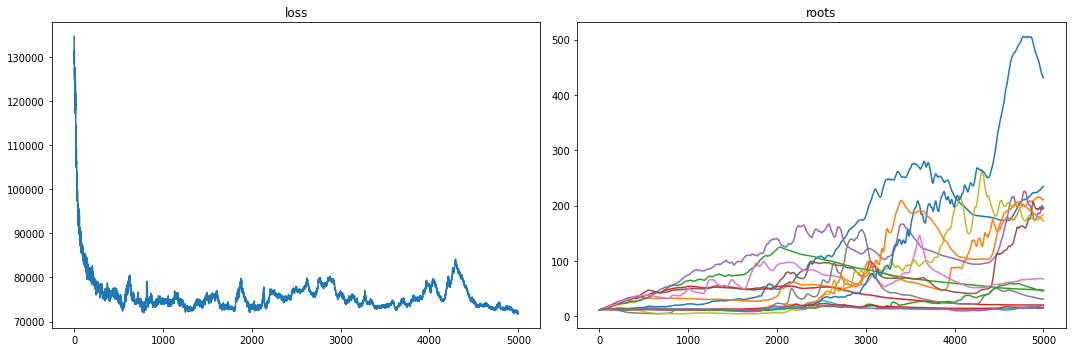

In [ ]:
inferred_prior_clusters, prior_cluster_predictor = infer_prior_clusters_SVI(cluster_priors, n_steps=5_000)

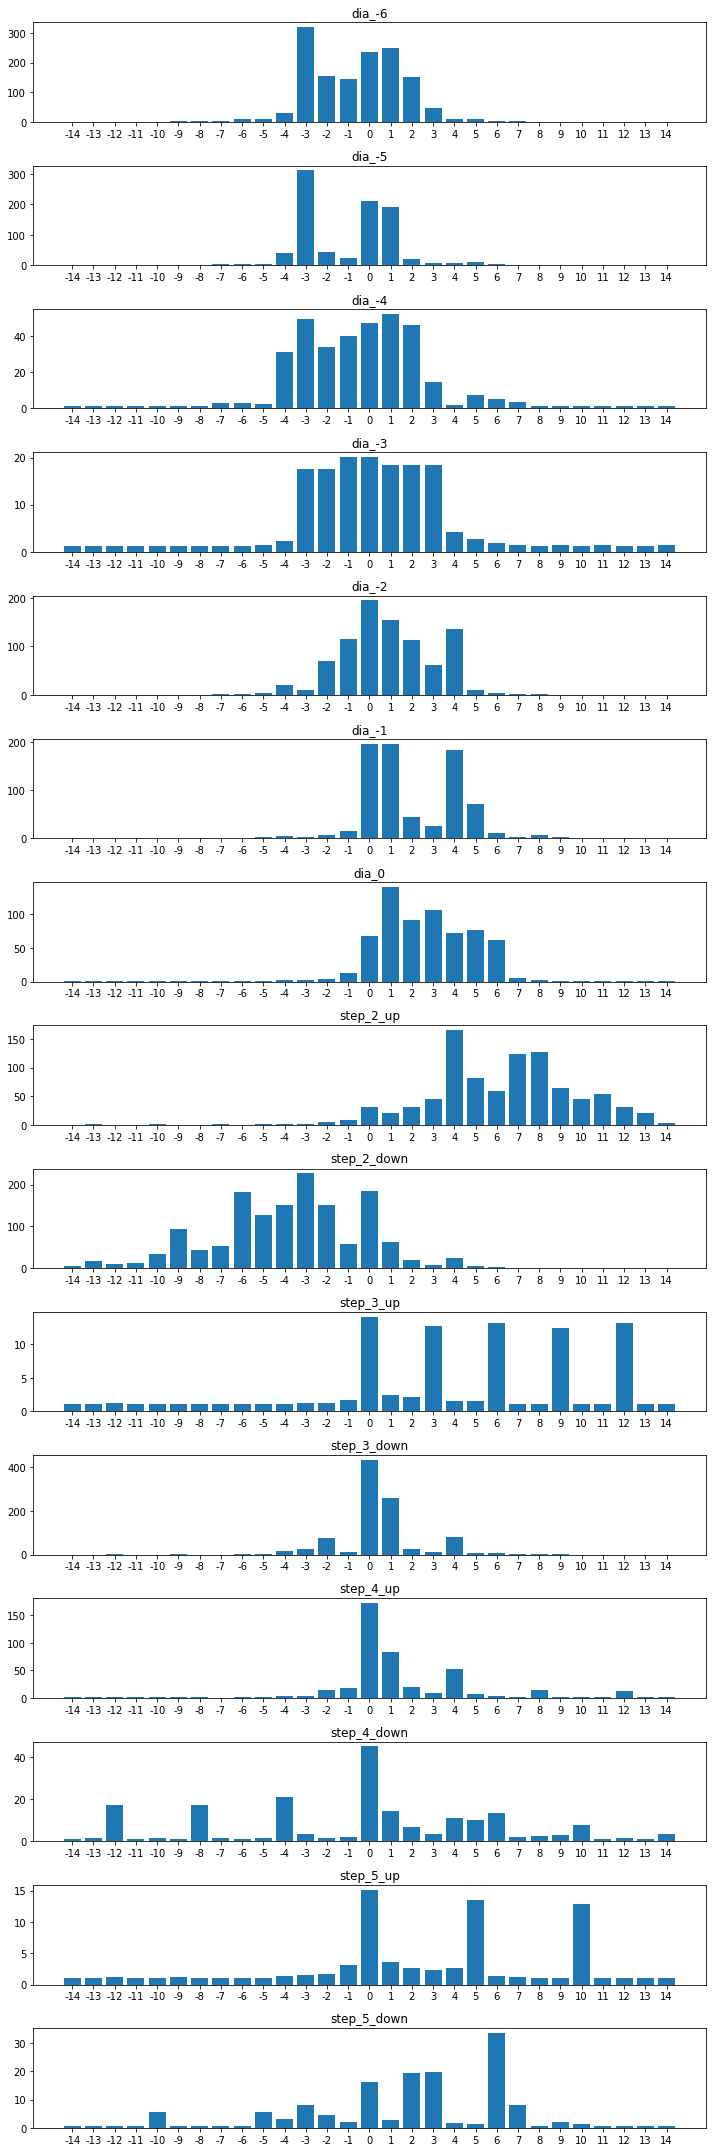

In [ ]:
plot_chord_types(inferred_prior_clusters, cluster_names)

# Grammars as Probabilistic Programs

- grammar as program
  - derivation = program execution
  - inference: parsing (otherwise vanishing probabilities)
- CYK
- combine simple example with Pyro model

# Unused

dcml_n_pieces = 973
dcml_pieces tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


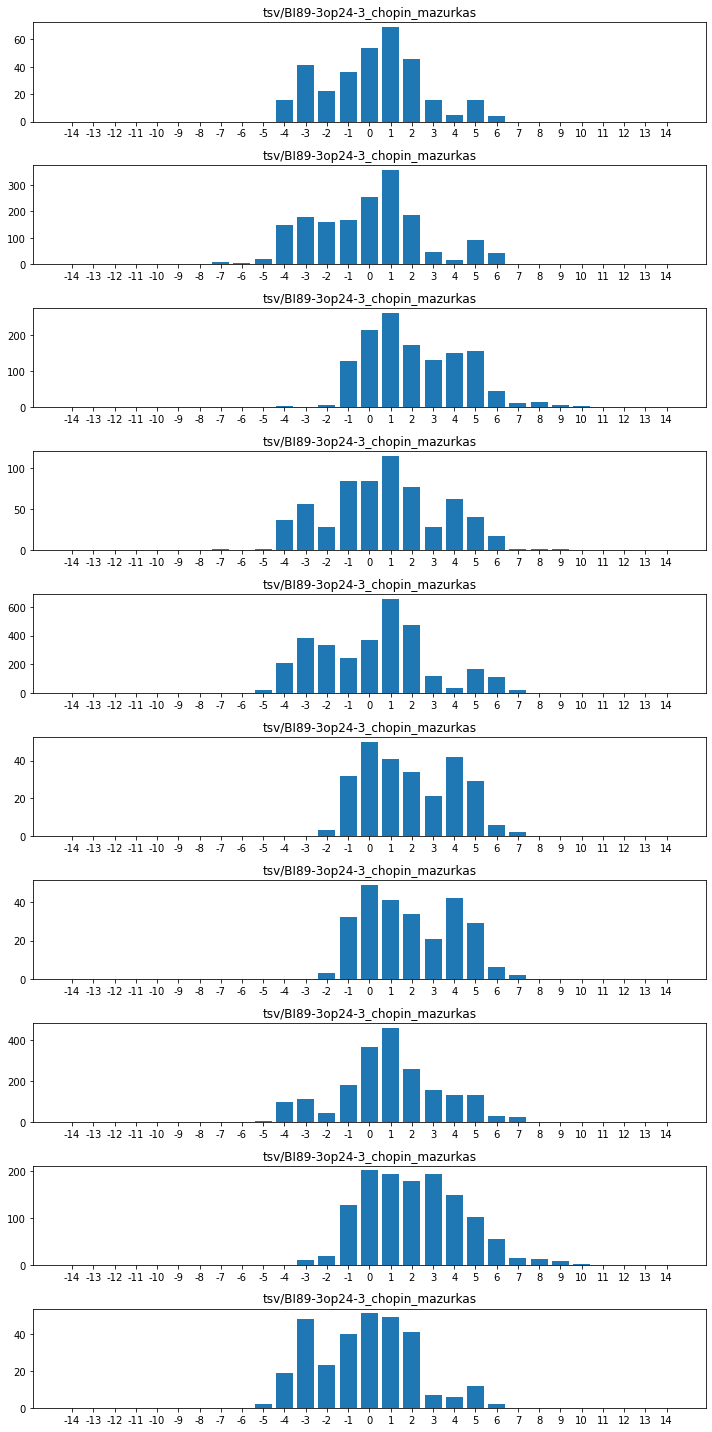

In [ ]:
df_profiles = pd.read_csv('profiles.tsv', sep='\t')
dcml_n_pieces = len(df_profiles.piece.unique())
dcml_pieces = torch.zeros(dcml_n_pieces, n_pcs, device=device)
for i, (_, grp) in enumerate(df_profiles.groupby('piece')):
  for pc, count in zip(grp.tpc, grp['count']):
    dcml_pieces[i, pc_to_index(pc)] = count

print("dcml_n_pieces =", dcml_n_pieces)
print("dcml_pieces", dcml_pieces)
plot_chord_types(dcml_pieces[0:10].cpu(), df_profiles.piece)